# Training LayoutLM-v3 model on Annoted Passport Dataset

Dataset:
[Link](https://huggingface.co/datasets/EphronM/Annotated_passport_images)
The passport dataset consists of 73 , contains key information categories, a combined annoted dataset of Indian, pakistan, USA passports public datasets. 58 and 17 images  are used for training and test respectively.

For more information on the dataset, do refer 
Hongbin Sun, Zhanghui Kuang, Xiaoyu Yue, Chenhao Lin, and Wayne Zhang. 2021. Spatial Dual-Modality Graph Reasoning for Key Information Extraction. arXiv. DOI:https://doi.org/10.48550/ARXIV.2103.14470

This Notebook is inspired from Mr.Niels Rogge [notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/LayoutLMv3/Fine_tune_LayoutLMv3_on_FUNSD_(HuggingFace_Trainer).ipynb) for training LayoutLMv3 model from scratch.


This notebook is divided into three part namely:

1. Training
2. Testing
3. Inference on Gradio

Gradio Demo of LayoutLM v3 is  deployed at Huggingface spaces and is  available from the [notebook](https://huggingface.co/spaces/Theivaprakasham/wildreceipt): https://huggingface.co/spaces/Theivaprakasham/wildreceipt


Please do support with a like if you enjoy reading through the notebook or the demo.

Thank you Folks.

In [1]:
!nvidia-smi

Tue Aug  6 14:27:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       On  | 00000000:00:1E.0 Off |                    0 |
| N/A   33C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Jun_13_19:16:58_PDT_2023
Cuda compilation tools, release 12.2, V12.2.91
Build cuda_12.2.r12.2/compiler.32965470_0


In [3]:
!lscpu

Architecture:                       x86_64
CPU op-mode(s):                     32-bit, 64-bit
Byte Order:                         Little Endian
Address sizes:                      46 bits physical, 48 bits virtual
CPU(s):                             8
On-line CPU(s) list:                0-7
Thread(s) per core:                 2
Core(s) per socket:                 4
Socket(s):                          1
NUMA node(s):                       1
Vendor ID:                          GenuineIntel
CPU family:                         6
Model:                              85
Model name:                         Intel(R) Xeon(R) Platinum 8259CL CPU @ 2.50G
                                    Hz
Stepping:                           7
CPU MHz:                            2499.998
BogoMIPS:                           4999.99
Hypervisor vendor:                  KVM
Virtualization type:                full
L1d cache:                          128 KiB
L1i cache:                          128 KiB
L2 cache:     

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git 
!pip install -q datasets seqeval 
!pip install gradio
!sudo apt install tesseract-ocr
!pip install pytesseract

In [ ]:
!huggingface-cli login

In [71]:
from datasets import load_dataset

dataset = load_dataset("EphronM/Annotated_passport_images")


Generating test split: 100%|██████████| 15/15 [00:00<00:00, 382.90 examples/s]


In [72]:
dataset

DatasetDict({
    train: Dataset({
        features: ['words', 'bboxes', 'ner_tags', 'image_url', 'image'],
        num_rows: 58
    })
    test: Dataset({
        features: ['words', 'bboxes', 'ner_tags', 'image_url', 'image'],
        num_rows: 15
    })
})

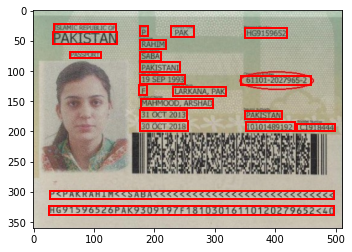

In [73]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image


def plot_bounding_boxes(image, boxes):
    original_width, original_height = image.size
    
    # Create a plot
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    # Plot each bounding box
    for box in boxes:
        # Calculate the coordinates and dimensions
        x = box[0] / 1000 * original_width
        y = box[1] / 1000 * original_height
        width = box[2] / 1000 * original_width
        height = box[3] / 1000 * original_height
        
        # Convert to integers
        x = int(round(x))
        y = int(round(y))
        width = int(round(width))
        height = int(round(height))
        
        rect = patches.Rectangle(
            (x, y),
            width,
            height,
            linewidth=2,
            edgecolor='r',
            facecolor='none'
        )
        ax.add_patch(rect)
    
    plt.show()
    
# Example usage
image = dataset["test"][1]["image"]
bounding_boxes =  dataset["test"][1]["bboxes"] # Example bounding boxes
plot_bounding_boxes(image, bounding_boxes)


In [64]:
dataset['train'].features

{'words': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'image_url': Value(dtype='string', id=None),
 'image': Image(mode=None, decode=True, id=None)}

In [65]:
id2label = {
    0 : "others",
    1 : "type",
    2 : "code",
    3 : "passport_no",
    4 : "surname",
    5 : "given_name",
    6 : "nationality",
    7 : "data_of_birth",
    8 : "place_of_birth",
    9 : "data_of_issue",
    10 : "sex",
    11 : "mrz"
}

In [74]:
example = dataset["train"][0]
example["image_url"]

'https://huggingface.co/datasets/EphronM/passport_image_storage/resolve/main/images/us_original_16.png'

In [75]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get(example["image_url"])
img = Image.open(BytesIO(response.content))

In [70]:
response.content

b'Entry not found'

In [68]:
from transformers import AutoProcessor

# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

In [83]:

features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "words"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

In [79]:
dataset["train"].column_names

['words', 'bboxes', 'ner_tags', 'image_url', 'image']

In [34]:
label2id = {v:k for k,v in id2label.items()}
label_list = list(id2label.values())
num_labels = len(label_list)
label_list

['others',
 'type',
 'code',
 'passport_no',
 'surname',
 'given_name',
 'nationality',
 'data_of_birth',
 'place_of_birth',
 'data_of_issue',
 'sex',
 'mrz']

In [35]:
from PIL import Image
import os


In [86]:


def prepare_examples(examples):
  images = [image.convert("RGB") for image in examples[image_column_name]] #Image.open(examples[image_column_name])
  words = examples[text_column_name]
  boxes = examples[boxes_column_name]
  word_labels = examples[label_column_name]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

  return encoding

In [87]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(ClassLabel(names=label_list)),
})

train_dataset = dataset["train"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

eval_dataset = dataset["test"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Map:   0%|          | 0/58 [00:00<?, ? examples/s]

Map: 100%|██████████| 15/15 [00:00<00:00, 32.48 examples/s]


In [88]:
train_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 58
})

In [89]:
example = train_dataset[0]
processor.tokenizer.decode(example["input_ids"])

'<s> WebeQeople Of the United States, inOrder to form a more perfect Union, establisb Justice insure domestic Tranquility provide for the common defence, promote the general Welfare and secure the Blessings of Liberty to ourselves and ourcosteriyido-ordain and establish.this Constaurou oribeUnited Staies otAmerco SIGNATURE OF BEARER/SIGNATUREDU TITULAIRE/FIRMA DEL TITULAR PASSPORT UNITED STATESOF AMIERICA PASSEPORT PASAPORTE Type/Type/Tipo Code/Code/Codigo Passport No./No. du Passeport/No dePasaporte P USA 826232091 Surname/ Nom/.Apellidos photo PARRISH Given Names/Prenoms/Nombres ASHLEY Nationality/Nationalite/Nacionalidad UNITED STATES OF AMERICA Date of birth/Date de naissance/Fecha de nacimiento 11Jan 2001 Place of birth / Lieu de naissance/Lugar de nacimiento Sex/Sexe/Sexo GABON F Date of issue / Date de delivrance / Fecha de expedicion Authority /Autorite/Autoridad O3Mar2011 United States Date of expiration/Date dexpiration/Fecha de caducidad Department of State 02Mar2021 Endorse

In [90]:
train_dataset.set_format("torch")

In [91]:
import torch

example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [92]:
eval_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 15
})

In [93]:
processor.tokenizer.decode(eval_dataset[0]["input_ids"])

'<s> E000240 ISLAMIC REPUBLIC OF PAK PAKISTAN GC4910811 QURESHI PASSPORT MUHAMMAD USMAN PAKISTANI 02JAN 1992 36302-3468081-1 M MULTAN,PAK AHMAD,MANZOOR 16OCT2015 PAKISTAN Date of Exp 140CT2020 11801878870E0027440 M M P<PSK2URESHI<<MUHAMMAD<USMAN<< GC49108118PAK9201028M20101423630234680100<74 P</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

In [94]:
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
  print(processor.tokenizer.decode([id]), label.item())

<s> -100
 We 0
be -100
Q -100
e -100
ople -100
 Of 0
 the -100
 United -100
 States -100
, -100
 in 0
Order -100
 to -100
 form -100
 a -100
 more -100
 perfect -100
 Union -100
, -100
 estab 0
lis -100
b -100
 Justice -100
 insure -100
 domestic -100
 Tr -100
anqu -100
ility -100
 provide 0
 for -100
 the -100
 common -100
 defence -100
, -100
 promote 0
 the -100
 general -100
 Welfare -100
 and -100
 secure -100
 the 0
 Bless -100
ings -100
 of -100
 Liberty -100
 to -100
 ourselves -100
 and -100
 our 0
c -100
oster -100
iy -100
ido -100
- -100
ord -100
ain -100
 and -100
 establish -100
. -100
this -100
 Const 0
aur -100
ou -100
 o -100
ribe -100
United -100
 Sta -100
ies -100
 ot -100
A -100
mer -100
co -100
 SIGN 0
ATURE -100
 OF -100
 BE -100
AR -100
ER -100
/ -100
SIGN -100
AT -100
UR -100
ED -100
U -100
 TIT -100
UL -100
AI -100
RE -100
/ -100
FIR -100
MA -100
 DEL -100
 TIT -100
ULAR -100
 P 0
AS -100
SP -100
ORT -100
 UNITED 0
 STATES -100
OF -100
 AM -100
IER -100
ICA -100

In [95]:
from datasets import load_metric

metric = load_metric("seqeval")

In [96]:
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [97]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="layoutlmv3-ft-passport",
                                  max_steps=4000,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=100,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  report_to="wandb" ,
                                  push_to_hub=True,
                                  push_to_hub_model_id=f"layoutlmv3-finetuned-passport",
                                  )

/home/ubuntu/miniconda3/envs/trainer/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/ubuntu/miniconda3/envs/trainer/lib/python3.10/site-packages/transformers/training_args.py:2026: FutureWarning: `--push_to_hub_model_id` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_model_id` instead and pass the full repo name to this argument (in this case EphronM/layoutlmv3-finetuned-passport).
  warnings.warn(


In [49]:
from transformers.data.data_collator import default_data_collator

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

max_steps is given, it will override any value given in num_train_epochs


In [50]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: ephron-martin (ephron-canwill). Use `wandb login --relogin` to force relogin


/home/ubuntu/miniconda3/envs/trainer/lib/python3.10/site-packages/transformers/modeling_utils.py:1106: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,No log,0.628634,0.792969,0.777778,0.785300,0.889849
200,No log,0.194476,0.942308,0.938697,0.940499,0.971922
300,No log,0.083227,0.972973,0.965517,0.969231,0.987041
400,No log,0.055769,0.966038,0.980843,0.973384,0.987041
500,0.398000,0.052442,0.962406,0.980843,0.971537,0.987041
600,0.398000,0.046243,0.973485,0.984674,0.979048,0.989201
700,0.398000,0.054293,0.966038,0.980843,0.973384,0.987041
800,0.398000,0.046346,0.973485,0.984674,0.979048,0.989201
900,0.398000,0.056931,0.962406,0.980843,0.971537,0.987041
1000,0.013900,0.072862,0.951493,0.977011,0.964083,0.984881


/home/ubuntu/miniconda3/envs/trainer/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: others seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/ubuntu/miniconda3/envs/trainer/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: type seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/ubuntu/miniconda3/envs/trainer/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: code seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/ubuntu/miniconda3/envs/trainer/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: passport_no seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/ubuntu/miniconda3/envs/trainer/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: surname seems not to be NE tag

TrainOutput(global_step=4000, training_loss=0.053229335129261014, metrics={'train_runtime': 1686.2228, 'train_samples_per_second': 4.744, 'train_steps_per_second': 2.372, 'total_flos': 2123451629568000.0, 'train_loss': 0.053229335129261014, 'epoch': 137.93103448275863})

In [51]:
trainer.evaluate()

/home/ubuntu/miniconda3/envs/trainer/lib/python3.10/site-packages/transformers/modeling_utils.py:1106: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


/home/ubuntu/miniconda3/envs/trainer/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: others seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/ubuntu/miniconda3/envs/trainer/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: type seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/ubuntu/miniconda3/envs/trainer/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: code seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/ubuntu/miniconda3/envs/trainer/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: passport_no seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/ubuntu/miniconda3/envs/trainer/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: surname seems not to be NE tag

{'eval_loss': 0.06545965373516083,
 'eval_precision': 0.9734848484848485,
 'eval_recall': 0.9846743295019157,
 'eval_f1': 0.979047619047619,
 'eval_accuracy': 0.9892008639308856,
 'eval_runtime': 1.4443,
 'eval_samples_per_second': 10.386,
 'eval_steps_per_second': 5.539,
 'epoch': 137.93103448275863}

In [52]:
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/EphronM/layoutlmv3-finetuned-passport/commit/f7a55c24a5f8919def085cc0ca0be825f3c1320e', commit_message='End of training', commit_description='', oid='f7a55c24a5f8919def085cc0ca0be825f3c1320e', pr_url=None, pr_revision=None, pr_num=None)

# Inference

In [98]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained("layoutlmv3-ft-passport")

In [99]:
example = dataset["test"][0]
print(example.keys())

image = example["image"]
words = example["words"]
boxes = example["bboxes"]
word_labels = example["ner_tags"]

encoding = processor(image, words, boxes=boxes, word_labels=word_labels, return_tensors="pt")
for k,v in encoding.items():
  print(k,v.shape)

dict_keys(['words', 'bboxes', 'ner_tags', 'image_url', 'image'])
input_ids torch.Size([1, 128])
attention_mask torch.Size([1, 128])
bbox torch.Size([1, 128, 4])
labels torch.Size([1, 128])
pixel_values torch.Size([1, 3, 224, 224])


In [100]:
with torch.no_grad():
  outputs = model(**encoding)

logits = outputs.logits
print(logits.shape)

predictions = logits.argmax(-1).squeeze().tolist()
print(predictions)

/home/ubuntu/miniconda3/envs/trainer/lib/python3.10/site-packages/transformers/modeling_utils.py:1106: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


torch.Size([1, 128, 12])
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 3, 3, 3, 3, 4, 4, 4, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 10, 8, 8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 3, 11, 11, 0, 1, 0]


In [101]:
labels = encoding.labels.squeeze().tolist()
print(labels)

[-100, 0, -100, -100, 0, -100, -100, -100, -100, -100, -100, -100, 2, -100, 0, -100, -100, -100, 3, -100, -100, -100, 4, -100, -100, 0, -100, -100, -100, 5, -100, -100, -100, -100, -100, 6, -100, -100, -100, 7, -100, -100, -100, 0, -100, -100, -100, -100, -100, -100, -100, 10, 8, -100, -100, -100, -100, -100, 0, -100, -100, -100, -100, -100, -100, -100, 9, -100, -100, -100, 0, -100, -100, -100, 0, -100, -100, 0, -100, -100, 0, -100, -100, -100, -100, -100, -100, -100, -100, 10, 10, 11, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 11, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 1, -100]


In [102]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

In [104]:
!pip install -q fuzzywuzzy

In [105]:
import pandas as pd
from fuzzywuzzy import fuzz

def create_label_word_dict(labels, words):
    # Define the list of labels
    predefined_labels = [
        'type', 'code', 'passport_no', 'surname', 
        'given_name', 'nationality', 'data_of_birth', 
        'place_of_birth', 'data_of_issue', 'sex', 'mrz'
    ]
    
    # Initialize the dictionary with empty lists
    label_word_dict = {label: [] for label in predefined_labels}
    
    # Iterate through the labels and words
    for label, word in zip(labels, words):
        if label in label_word_dict:
            label_word_dict[label].append(word)
    
    return label_word_dict
def calculate_support_full_partial(y_true, y_pred):
    y_true_stripped = [item.strip().lower() for item in y_true]
    y_pred_stripped = [item.strip().lower() for item in y_pred]
    
    full_matches = sum(1 for true, pred in zip(y_true_stripped, y_pred_stripped) if true == pred)
    partial_matches = sum(1 for true, pred in zip(y_true_stripped, y_pred_stripped) if true != pred and fuzz.partial_ratio(true, pred) >= 90)
    
    total_support = len(y_true)
    score = full_matches / total_support 
    missed = total_support - (full_matches + partial_matches)
    
    return score, total_support, full_matches, partial_matches, missed

def generate_report(true_lists, pred_lists):
    metrics = []

    for metric_name in true_lists.keys():
        y_true, y_pred = true_lists[metric_name], pred_lists[metric_name]
        
        if y_true and y_pred:
            score, support, full_matches, partial_matches, missed = calculate_support_full_partial(y_true, y_pred)
        else:
            score = support = full_matches = partial_matches = missed = 0
        
        metrics.append({
            "Metric": metric_name,
            "Score": score,
            "Full Matches": full_matches,
            "Partial Matches": partial_matches,
            "Missed": missed,
            "Total Support": support,
        })
    
    return pd.DataFrame(metrics)

/home/ubuntu/miniconda3/envs/trainer/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [110]:
label2color= {
    'others': "black",
    'type': 'red',
    'code': "red",
    'passport_no': 'yellow',
    'surname': 'green',
    'given_name': 'green',
    'nationality': 'blue',
    'data_of_birth': 'white',
    'place_of_birth': 'red',
    'data_of_issue': 'white',
    'sex': "green",
    'mrz': 'yellow'
 }

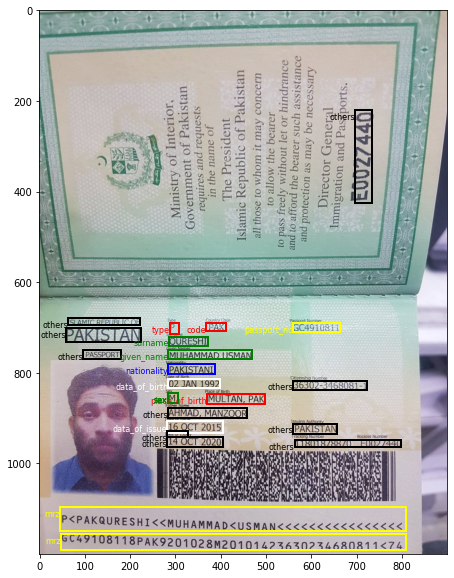

In [111]:
def plot_bounding_boxes(image, boxes, labels, save_dir=None):
    # Load the image
    original_width, original_height = image.size
    
    # Create a larger plot
    fig, ax = plt.subplots(1, figsize=(25, 10))  # Adjust figsize as needed
    ax.imshow(image)
    
    # Plot each bounding box
    for box, label in zip(boxes, labels):
        # Calculate the coordinates and dimensions
        x = box[0] / 1000 * original_width
        y = box[1] / 1000 * original_height
        width = box[2] / 1000 * original_width
        height = box[3] / 1000 * original_height
        
        # Convert to integers
        x = int(round(x))
        y = int(round(y))
        width = int(round(width))
        height = int(round(height))
        
        # Get the color based on the label
        color = label2color.get(label, 'black')  # Default to black if label not found
        
        rect = patches.Rectangle(
            (x, y),
            width,
            height,
            linewidth=2,
            edgecolor=color,
            facecolor='none'
        )
        ax.add_patch(rect)
        
        # Display the label text near the bounding box
        ax.text(
            x, 
            y +20,  # Position text above the bounding box
            label,
            color=color,
            fontsize=8,
            ha='right'
        )
    if save_dir is None:
        plt.show()
    else:
        # Save the image in the specified directory
        if not os.path.exists(save_dir):
            os.makedirs(save_dir) 
        
        # Get the base name of the image file and create the save path
        #save_path = os.path.join(save_dir, os.path.basename(image_path))
        
        # Save the plot
        plt.axis('off')  # Hide axes
        #plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close()
    
plot_bounding_boxes(example["image"], boxes, true_predictions)

## Prediction final json

In [112]:
import re

def create_empty_lists_dict():
    keys = [
        'passport_number',
        'surname',
        'given_name',
        'nationality',
        'date_of_birth',
        'place_of_birth',
        'sex',
        'date_of_issue'
    ]
    return {key: [] for key in keys}

def normalize_dict(d):
    def normalize_value(value):
        if value is None:
            return ""
        if len(value) == 1:
            value = value[0]
        else:
            value = " ".join(value)
        return re.sub(r'\b[A-Za-z]+\b', lambda match: match.group(0).lower(), value)
    
    final_dict = {}
    for k, v in d.items():
        k = k.replace("_no", "_number").replace("data", "date")
        final_dict[k.replace(" ", "_").lower()] = normalize_value(v)
    return final_dict        

def map_sex(value):
    if value is None: return ""
    if value.strip().lower() == "female":
        return "F"
    elif value.strip().lower() == "male":
        return "M"
    else:
        return value.strip()[:1].upper()  # Default to first character if longer than one character



In [113]:
dataset["test"]

Dataset({
    features: ['words', 'bboxes', 'ner_tags', 'image_url', 'image'],
    num_rows: 15
})

In [118]:
from transformers import AutoModelForTokenClassification
from tqdm import tqdm

model = AutoModelForTokenClassification.from_pretrained("layoutlmv3-ft-passport")
processor = AutoProcessor.from_pretrained("layoutlmv3-ft-passport", apply_ocr=False)

save_dir = "pred_dump/images"

true_lists = create_empty_lists_dict()
pred_lists = create_empty_lists_dict()

for data in tqdm(dataset["test"]):
    image = data["image"].convert("RGB")
    words = data["words"]
    boxes = data["bboxes"]
    word_labels = data["ner_tags"]

    encoding = processor(image, words, boxes=boxes, word_labels=word_labels, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**encoding)

    logits = outputs.logits
    predictions = logits.argmax(-1).squeeze().tolist()
    labels = encoding.labels.squeeze().tolist()
    token_boxes = encoding.bbox.squeeze().tolist()
    
    true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
    true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
    true_dict = normalize_dict(create_label_word_dict(true_labels, words))
    pred_dict = normalize_dict(create_label_word_dict(true_predictions, words))

    for key in true_lists.keys():
        true_lists[key].append(true_dict.get(key, ''))
        pred_lists[key].append(pred_dict.get(key, ''))

    #plot_bounding_boxes(data["image_path"], boxes, true_predictions, save_dir)
    

final_report = generate_report(true_lists, pred_lists)


  0%|          | 0/15 [00:00<?, ?it/s]

/home/ubuntu/miniconda3/envs/trainer/lib/python3.10/site-packages/transformers/modeling_utils.py:1106: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
100%|██████████| 15/15 [00:04<00:00,  3.46it/s]


In [119]:
final_report

,Metric,Score,Full Matches,Partial Matches,Missed,Total Support
0,passport_number,1.0,15,0,0,15
1,surname,1.0,15,0,0,15
2,given_name,1.0,15,0,0,15
3,nationality,1.0,15,0,0,15
4,date_of_birth,1.0,15,0,0,15
5,place_of_birth,1.0,15,0,0,15
6,sex,1.0,15,0,0,15
7,date_of_issue,1.0,15,0,0,15


AS the dataset is small, the layout model might have overfitted on the train dataset.

In [120]:
dataset

DatasetDict({
    train: Dataset({
        features: ['words', 'bboxes', 'ner_tags', 'image_url', 'image'],
        num_rows: 58
    })
    test: Dataset({
        features: ['words', 'bboxes', 'ner_tags', 'image_url', 'image'],
        num_rows: 15
    })
})

In [126]:
label2id

{'others': 0,
 'type': 1,
 'code': 2,
 'passport_no': 3,
 'surname': 4,
 'given_name': 5,
 'nationality': 6,
 'data_of_birth': 7,
 'place_of_birth': 8,
 'data_of_issue': 9,
 'sex': 10,
 'mrz': 11}

In [125]:
dataset['ner_tags'][0]

[0, 0, 2, 0, 3, 4, 0, 5, 6, 7, 0, 10, 8, 0, 9, 0, 0, 0, 0, 10, 10, 11, 11, 1]

# Inference using Gradio

In [134]:
import os

import gradio as gr
import numpy as np
from transformers import AutoModelForTokenClassification
from datasets.features import ClassLabel
from transformers import AutoProcessor
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D
import torch
from datasets import load_metric
from transformers import LayoutLMv3ForTokenClassification
from transformers.data.data_collator import default_data_collator


from transformers import AutoModelForTokenClassification
from datasets import load_dataset
from PIL import Image, ImageDraw, ImageFont


processor = AutoProcessor.from_pretrained("EphronM/layoutlmv3-finetuned-passport", apply_ocr=True)
## use paddleOCR instead of in-built ocr for better result
model = AutoModelForTokenClassification.from_pretrained("EphronM/layoutlmv3-finetuned-passport")



# load image example
dataset = load_dataset("EphronM/Annotated_passport_images", split="test")
dataset[2]["image"].convert("RGB").save("example1.png")
dataset[3]["image"].convert("RGB").save("example2.png")
dataset[5]["image"].convert("RGB").save("example3.png")

# define id2label, label2color
labels = dataset.features['ner_tags'].feature.names
id2label = {v: k for v, k in enumerate(labels)}

def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]


def iob_to_label(label):
    return label



def process_image(image):

    print(type(image))
    width, height = image.size

    # encode
    encoding = processor(image, truncation=True, return_offsets_mapping=True, return_tensors="pt")
    offset_mapping = encoding.pop('offset_mapping')

    # forward pass
    outputs = model(**encoding)

    # get predictions
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    token_boxes = encoding.bbox.squeeze().tolist()

    # only keep non-subword predictions
    is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0
    true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
    true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]

    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(true_predictions, true_boxes):
        predicted_label = iob_to_label(prediction)
        draw.rectangle(box, outline=label2color[predicted_label])
        draw.text((box[0]+10, box[1]-10), text=predicted_label, fill=label2color[predicted_label], font=font)
    
    return image


title = "Passport information extraction using LayoutLMv3 model"
description = "The key value information from passport can be extracted - We use Microsoft's LayoutLMv3 trained on IND/PAK/US Passport Dataset to predict the type, code, passport_no, surname, given_name, nationality, data_of_birth, place_of_birth, data_of_issue, sex, mrz. To use it, simply upload an image or use the example image below. Results will show up in a few seconds."

article="<b>References</b><br>[1] Y. Xu et al., “LayoutLMv3: Pre-training for Document AI with Unified Text and Image Masking.” 2022. <a href='https://arxiv.org/abs/2204.08387'>Paper Link</a><br>[2]  <a href='https://github.com/NielsRogge/Transformers-Tutorials/tree/master/LayoutLMv3'>LayoutLMv3 training and inference</a><br>[3] Hongbin Sun, Zhanghui Kuang, Xiaoyu Yue, Chenhao Lin, and Wayne Zhang. 2021. Spatial Dual-Modality Graph Reasoning for Key Information Extraction. arXiv. DOI:https://doi.org/10.48550/ARXIV.2103.14470  <a href='https://doi.org/10.48550/ARXIV.2103.14470'>Paper Link</a>" 

examples =[['example1.png'],['example2.png'],['example3.png']]

css = """.output_image, .input_image {height: 600px !important}"""

iface = gr.Interface(fn=process_image, 
                     inputs=gr.Image(type="pil"), 
                     outputs=gr.Image(type="pil", label="annotated image"),
                     title=title,
                     description=description,
                     article=article,
                     examples=examples,
                     css=css,
                     analytics_enabled=True)


iface.launch(inline=False, share=True, debug=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://6f81b76e2f3906c1ac.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://6f81b76e2f3906c1ac.gradio.live
